In [72]:
import numpy as np
from keras.layers import Input, Dense, Lambda, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import json
from collections import Counter
from io import BytesIO
import PIL
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import clear_output, Image, display, HTML

In [79]:
batch_size = 250 # batch size

def augment(icons, labels, size):
    aug_icons = []
    aug_labels = []
    for icon, label in zip(icons, labels):
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                aug_labels.append(label)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
            if flip % 2 == 0:
                icon = np.flipud(icon)
    aug_icons = np.asarray(aug_icons) / 255

    return aug_icons, np.asarray(aug_labels)

def load_icons(train_size=0.90, size=28):
    icon_index = json.load(open('icons/index.json'))
    cat_count = Counter(icon['category'] for icon in icon_index)
    cats = [cat for cat, count in cat_count.items() if count > 50]
    cat_to_index = {cat: idx for idx, cat in enumerate(cats)}
    x = []
    y = []
    img_rows, img_cols = size, size
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        cat_idx = cat_to_index.get(icon['category'])
        if cat_idx is None:
            continue
        img_path = 'icons/png%d/%s.png' % (size, icon['name'])
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
        y.append(cat_idx)
    target_size = len(x) - (len(x) % batch_size)
    x = x[:target_size]
    y = y[:target_size]
    x = np.asarray(x)
    y = np.asarray(y)
    train_size = int(train_size * x.shape[0])
    train_size -= train_size % batch_size
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size)
    x_train, y_train = augment(x_train, y_train, size=size)
    x_test, y_test = augment(x_test, y_test, size=size)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load_icons(size=32)
x_train.shape

/Users/douwe/Dropbox/Douwe/Proj/notebooks/venv3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(64000, 32, 32, 1)

In [126]:
batch_size = 250
latent_space_depth = 64

def sample_z(args):
    z_mean, z_log_var = args
    eps = K.random_normal(shape=(batch_size, latent_space_depth), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * eps


In [127]:
def VariationalAutoEncoder(num_pixels):
    pixels = Input(shape=(num_pixels, num_pixels, 1))
    channels = 4
    x = pixels
    for i in range(4):
        left = Conv2D(channels, (3, 3), activation='relu', padding='same')(x)
        right = Conv2D(channels, (2, 2), activation='relu', padding='same')(x)
        conc = Concatenate()([left, right])
        x = MaxPooling2D((2, 2), padding='same')(conc)
        channels *= 2

    x = Dense(32)(x) 
    encoder_hidden = Flatten()(x)

    z_mean = Dense(latent_space_depth, activation='linear', name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_space_depth, activation='linear', name='z_log_var')(encoder_hidden)
    
    def KL_loss(y_true, y_pred):
        return 0.5 * K.sum(K.exp(z_log_var) + K.square(z_mean) - 1 - z_log_var, axis=1)

    def reconstruction_loss(y_true, y_pred):
        y_true = K.batch_flatten(y_true)
        y_pred = K.batch_flatten(y_pred)
        return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)    

    def total_loss(y_true, y_pred):
        return KL_loss(y_true, y_pred) + reconstruction_loss(y_true, y_pred)

    z = Lambda(sample_z, output_shape=(latent_space_depth, ))([z_mean, z_log_var])
    
    up_samp0 = UpSampling2D((2, 2))
    up_conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')
    up_samp1 = UpSampling2D((2, 2))
    up_conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')
    up_samp2 = UpSampling2D((2, 2))
    up_conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')
    up_samp3 = UpSampling2D((2, 2))
    up_conv4 = Conv2D(4, (3, 3), activation='relu', padding='same')
    up_samp4 = UpSampling2D((2, 2))
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')

    decoder_in = Input(shape=(latent_space_depth,))
    d_x = Reshape((1, 1, latent_space_depth))(decoder_in)
    d_x = up_samp0(d_x)
    d_x = up_conv1(d_x)
    d_x = up_samp1(d_x)
    d_x = up_conv2(d_x)
    d_x = up_samp2(d_x)
    d_x = up_conv3(d_x)
    d_x = up_samp3(d_x)
    d_x = up_conv4(d_x)
    d_x = up_samp4(d_x)
    decoder_out= decoded(d_x)

    decoder = Model(decoder_in, decoder_out)    

    a_x = Reshape((1, 1, latent_space_depth))(z)
    a_x = up_samp0(a_x)
    a_x = up_conv1(a_x)
    a_x = up_samp1(a_x)
    a_x = up_conv2(a_x)
    a_x = up_samp2(a_x)
    a_x = up_conv3(a_x)
    a_x = up_samp3(a_x)
    a_x = up_conv4(a_x)
    a_x = up_samp4(a_x)
    outputs= decoded(a_x)
    
    auto_encoder = Model(pixels, outputs)

    auto_encoder.compile(optimizer=Adam(lr=0.001), 
                         loss=total_loss,
                         metrics=[KL_loss, reconstruction_loss])
    
    return auto_encoder, decoder

auto_encoder, decoder = VariationalAutoEncoder(x_train.shape[1])
auto_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_275 (Conv2D)             (None, 32, 32, 4)    40          input_54[0][0]                   
__________________________________________________________________________________________________
conv2d_276 (Conv2D)             (None, 32, 32, 4)    20          input_54[0][0]                   
__________________________________________________________________________________________________
concatenate_93 (Concatenate)    (None, 32, 32, 8)    0           conv2d_275[0][0]                 
                                                                 conv2d_276[0][0]                 
__________

In [128]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((64000, 32, 32, 1), (64000,), (8000, 32, 32, 1), (8000,))

In [129]:
auto_encoder.fit(x_train, x_train, verbose=1, 
                 batch_size=batch_size, epochs=100,
                 validation_data=(x_test, x_test))

Train on 64000 samples, validate on 8000 samples
Epoch 1/100
64000/64000 [==============================] - 65s 1ms/step - loss: 499.2450 - KL_loss: 7.6328 - reconstruction_loss: 491.6122 - val_loss: 471.8895 - val_KL_loss: 12.5769 - val_reconstruction_loss: 459.3125
Epoch 2/100
64000/64000 [==============================] - 54s 851us/step - loss: 452.8894 - KL_loss: 16.0456 - reconstruction_loss: 436.8438 - val_loss: 442.2893 - val_KL_loss: 18.8033 - val_reconstruction_loss: 423.4859
Epoch 3/100
64000/64000 [==============================] - 55s 861us/step - loss: 433.6774 - KL_loss: 19.1470 - reconstruction_loss: 414.5305 - val_loss: 431.2543 - val_KL_loss: 20.0361 - val_reconstruction_loss: 411.2182
Epoch 4/100
64000/64000 [==============================] - 56s 882us/step - loss: 424.4016 - KL_loss: 20.4182 - reconstruction_loss: 403.9834 - val_loss: 424.0011 - val_KL_loss: 21.2451 - val_reconstruction_loss: 402.7559
Epoch 5/100
64000/64000 [==============================] - 63s 983

Epoch 38/100
64000/64000 [==============================] - 65s 1ms/step - loss: 387.7193 - KL_loss: 30.5242 - reconstruction_loss: 357.1951 - val_loss: 391.7882 - val_KL_loss: 30.0762 - val_reconstruction_loss: 361.7120
Epoch 39/100
64000/64000 [==============================] - 69s 1ms/step - loss: 387.3739 - KL_loss: 30.6735 - reconstruction_loss: 356.7004 - val_loss: 391.8194 - val_KL_loss: 30.6645 - val_reconstruction_loss: 361.1548
Epoch 40/100
64000/64000 [==============================] - 65s 1ms/step - loss: 387.0826 - KL_loss: 30.8094 - reconstruction_loss: 356.2732 - val_loss: 391.0631 - val_KL_loss: 30.6201 - val_reconstruction_loss: 360.4431
Epoch 41/100
64000/64000 [==============================] - 66s 1ms/step - loss: 386.8353 - KL_loss: 30.9607 - reconstruction_loss: 355.8746 - val_loss: 391.0978 - val_KL_loss: 30.0480 - val_reconstruction_loss: 361.0497
Epoch 42/100
64000/64000 [==============================] - 66s 1ms/step - loss: 386.3496 - KL_loss: 31.1413 - recon

Epoch 75/100
64000/64000 [==============================] - 65s 1ms/step - loss: 379.8097 - KL_loss: 34.1036 - reconstruction_loss: 345.7061 - val_loss: 383.7904 - val_KL_loss: 33.8892 - val_reconstruction_loss: 349.9013
Epoch 76/100
64000/64000 [==============================] - 66s 1ms/step - loss: 379.6665 - KL_loss: 34.1388 - reconstruction_loss: 345.5277 - val_loss: 383.8588 - val_KL_loss: 34.8438 - val_reconstruction_loss: 349.0150
Epoch 77/100
64000/64000 [==============================] - 64s 995us/step - loss: 379.7187 - KL_loss: 34.1467 - reconstruction_loss: 345.5721 - val_loss: 383.9077 - val_KL_loss: 34.4939 - val_reconstruction_loss: 349.4138
Epoch 78/100
64000/64000 [==============================] - 66s 1ms/step - loss: 379.5834 - KL_loss: 34.2163 - reconstruction_loss: 345.3671 - val_loss: 383.9022 - val_KL_loss: 33.9420 - val_reconstruction_loss: 349.9602
Epoch 79/100
64000/64000 [==============================] - 62s 975us/step - loss: 379.3364 - KL_loss: 34.2485 - r

In [130]:
random_number = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
print(random_number)

[[-0.31302284 -1.15793563  0.68159348  0.51377343 -0.59150948  0.56829519
  -0.99952052 -0.72473238  0.45896827  0.38298489  0.43218469  0.61733656
   0.61353593 -0.5738053   0.63328231 -1.96568584  1.25702067  1.09299523
  -1.79046448  0.9213566   0.90887407  0.76346626 -0.37055644 -1.35505071
   0.31663698 -1.30439003 -0.05238562  0.06247551  0.79634133  0.37338501
  -0.13160589 -1.11477427 -1.10770606 -1.04510929 -0.2038191   0.12028837
   1.10597227 -0.10648598  0.06510927 -1.03522245  0.20526582 -0.34542557
   1.03310633  1.56625119  0.69040637  0.78216109 -0.05344754 -0.36900545
  -1.50981665  0.07112605  0.47746486  0.31469496 -0.60754881 -1.45340147
  -0.45495826 -0.19965223  0.43057036  1.37234754  0.7114865   0.12171981
   0.63783792 -1.17910167  1.55779135  0.36345002]]


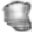

In [131]:
img_width, img_height = 32, 32
def decode_img(a):
    a = np.clip(a * 256, 0, 255).astype('uint8')
    return PIL.Image.fromarray(a)

decode_img(decoder.predict(random_number).reshape(img_width, img_height))


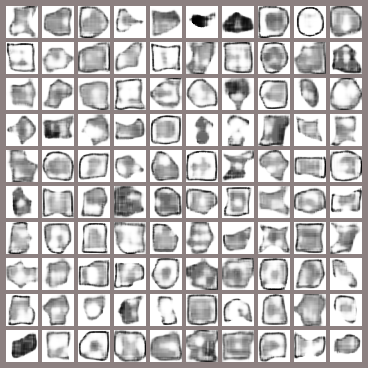

In [132]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (140, 128, 128))

for x in range(num_cells):
    for y in range(num_cells):
        vec = np.asarray([[np.random.normal() 
                            for _ in range(latent_space_depth)]])
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

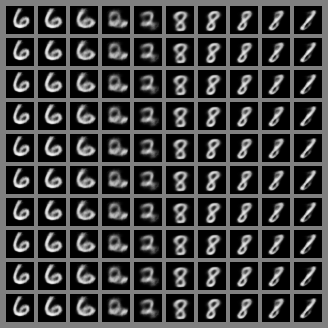

In [20]:
num_cells = 10

overview = PIL.Image.new('RGB', 
                         (num_cells * (img_width + 4) + 8, 
                          num_cells * (img_height + 4) + 8), 
                         (128, 128, 128))

vec = np.zeros((1, latent_space_depth))
for x in range(num_cells):
    vec[: 1] = (x * 3) / (num_cells - 1) - 1.5
    for y in range(num_cells):
#        vec[: 1] = (y * 3) / (num_cells - 1) - 1.5
        decoded = decoder.predict(vec)
        img = decode_img(decoded.reshape(img_width, img_height))
        overview.paste(img, (x * (img_width + 4) + 6, y * (img_height + 4) + 6))
overview

In [47]:
vec.shape

(1, 2)